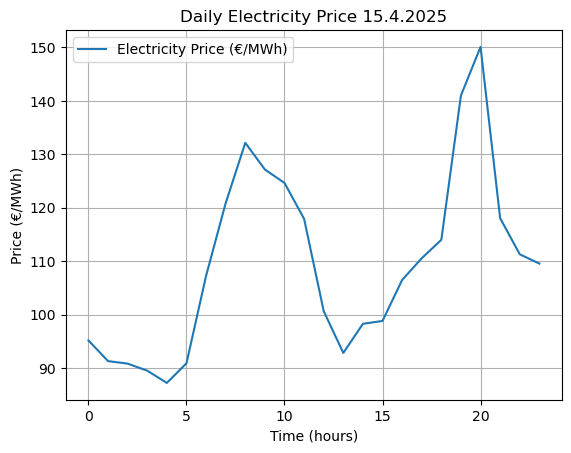

In [659]:
#PUN INDEX GME 15.4.2025
prices = np.array([
95.170000,
91.300000,
90.830000,
89.510000,
87.220000,
90.900000,
107.255020,
120.870000,
132.150000,
127.150000,
124.645060,
117.921710,
100.654380,
92.832060,
98.281420,
98.819200,
106.485520,
110.550000,
114.000000,
141.000000,
150.093950,
118.050000,
111.290000,
109.550000])
plt.plot(prices,label="Electricity Price (€/MWh)")
plt.xlabel("Time (hours)")
plt.ylabel("Price (€/MWh)")
plt.title("Daily Electricity Price 15.4.2025")
plt.grid(True)
plt.legend()
plt.show()

231.98043105810729


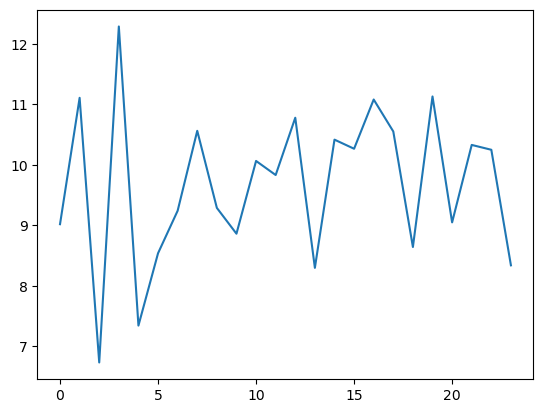

In [661]:
#example data
Inflow = np.random.normal(10,2,24)
plt.plot(Inflow)
print(sum(Inflow))

In [663]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# System Parameters (SI units)
max_head = 571.0  # Maximum head (elevation difference) [m]
max_volume = 7682000.0  # [m3]
reservoir_area = 670000.0  # Reservoir area [m^2]
max_level = max_volume / reservoir_area  # Maximum water level change [m]
min_level = 2.0  # Minimum level allowed in the reservoir [m]
gravity = 9.81  # Acceleration due to gravity [m/s^2]
water_density = 1000.0  # Density of water [kg/m^3]
efficiency_pump = 0.9  # Pump efficiency
efficiency_turbine = 0.9  # Turbine efficiency
max_power_turbine = 135e6  # Maximum generating power (135MW)
max_flow_rate = 33.0  # Maximum flow rate [m^3/s]

# Time parameters
days = 1
hours_per_day = 24
seconds_per_hour = 3600
time_steps_per_hour = 1 # 1 time step per hour
time_steps = days * hours_per_day * time_steps_per_hour
time_step_duration = seconds_per_hour / time_steps_per_hour # Duration of each time step in seconds

# Initial water level (can be a parameter to optimize as well)
initial_level = min_level + 0.5 * max_level  # Start in the middle
daily_level_change = 1.0 #amount of decrease of water level on a daily 

In [665]:
def objective_function(flow_rates, initial_level , price, inflow):
    """
    Objective function to maximize: Total energy generated minus pumping energy,
    accounting for electricity price.

    Args:
        flow_rates (np.array): Array of flow rates (m^3/s) for each time step.
                               Positive values for generation, negative for pumping.
        initial_level (float): Initial water level in the reservoir (m).
        price (np.array): Electricity price for each time step (€/Wh).

    Returns:
        float: Negative of the total profit (since scipy.optimize minimizes).
    """
    energy_generated = 0
    energy_consumed = 0
    water_level = initial_level
    profit = 0  # Initialize profit

    # Ensure flow_rates is a numpy array
    flow_rates = np.array(flow_rates)

    for t in range(time_steps):
        flow_rate = flow_rates[t]

        # Calculate head based on current water level
        head = max_head * (water_level / max_level)  # Simplified head calculation

        # Turbine (generation)
        if flow_rate > 0:
            power_out = efficiency_turbine * water_density * gravity * head * flow_rate
            # Limit power output to maximum turbine capacity
            power_out = min(power_out, max_power_turbine)
            energy_generated += power_out * time_step_duration  # in Joules
            water_level -= (flow_rate * time_step_duration) / reservoir_area
            water_level += (inflow[t] * time_step_duration) / reservoir_area
            profit += (power_out * time_step_duration / 3.6e6) * (price[t]/1000)  # Energy in Wh * price.

        # Pump
        elif flow_rate < 0:
            power_in = (water_density * gravity * head * abs(flow_rate)) / efficiency_pump
            energy_consumed += power_in * time_step_duration # in Joules
            water_level -= (flow_rate * time_step_duration) / reservoir_area  # flow_rate is negative
            water_level += (inflow[t] * time_step_duration) / reservoir_area
            profit -= (power_in * time_step_duration / 3.6e6) * (price[t]/1000) # Energy in kWh * price

        # No flow
        else:
            water_level += (inflow[t] * time_step_duration) / reservoir_area
            #pass # Water level remains the same.


    return -profit  # Minimize the negative of profit to maximize profit

In [667]:
def constraints(initial_level):
    """
    Constraints for the optimization:
    1.  Water level within limits.
    2.  Flow rate within limits.
    3.  Final water level close to initial level (optional, for cyclic operation).

    Args:
        initial_level: The initial water level of the reservoir.

    Returns:
        tuple: A tuple containing the constraints.
    """
    def min_level_constraint(flow_rates):
        """Calculates the water level at each time step and returns the minimum level."""
        min_water_level = float('inf')
        water_level = initial_level
        for t in range(time_steps):
            flow_rate = flow_rates[t]
            water_level -= (flow_rate * time_step_duration) / reservoir_area
            min_water_level = min(min_water_level, water_level)
        return min_water_level

    def max_level_constraint(flow_rates):
        """Calculates the water level at each time step and returns the maximum level."""
        max_water_level = float('-inf')
        water_level = initial_level
        for t in range(time_steps):
            flow_rate = flow_rates[t]
            water_level -= (flow_rate * time_step_duration) / reservoir_area
            max_water_level = max(max_water_level, water_level)
        return max_water_level
        
    def cyclic_operation_constraint(flow_rates):
        """Make sure that the water levle at the end of each day is within a certain margin as in the begining"""
        water_level = initial_level
        for t in range(time_steps):
            flow_rate = flow_rates[t]
            water_level -= (flow_rate * time_step_duration) / reservoir_area
        return water_level*daily_level_change - initial_level  # Should be 0 for perfect cyclic operation
        
       
    # Constraints are defined as a list of dictionaries.
    cons = [
        {'type': 'ineq', 'fun': min_level_constraint},  # Water level >= min_level
        {'type': 'ineq', 'fun': lambda x: max_level - max_level_constraint(x)},
        {'type': 'eq', 'fun': cyclic_operation_constraint}  # Enforce cyclic operation
         ]
    return cons 

Optimization terminated successfully    (Exit mode 0)
            Current function value: -24563.94242740915
            Iterations: 84
            Function evaluations: 2273
            Gradient evaluations: 84
Optimization successful!
Maximum Profit: €24,563.94
Energy Generated from Inflow: 102.05 MWh
Total Energy Generated: 3,058.93 MWh
Total Energy Consumed: 2,994.21 MWh
Final Water Level: 7.73 m


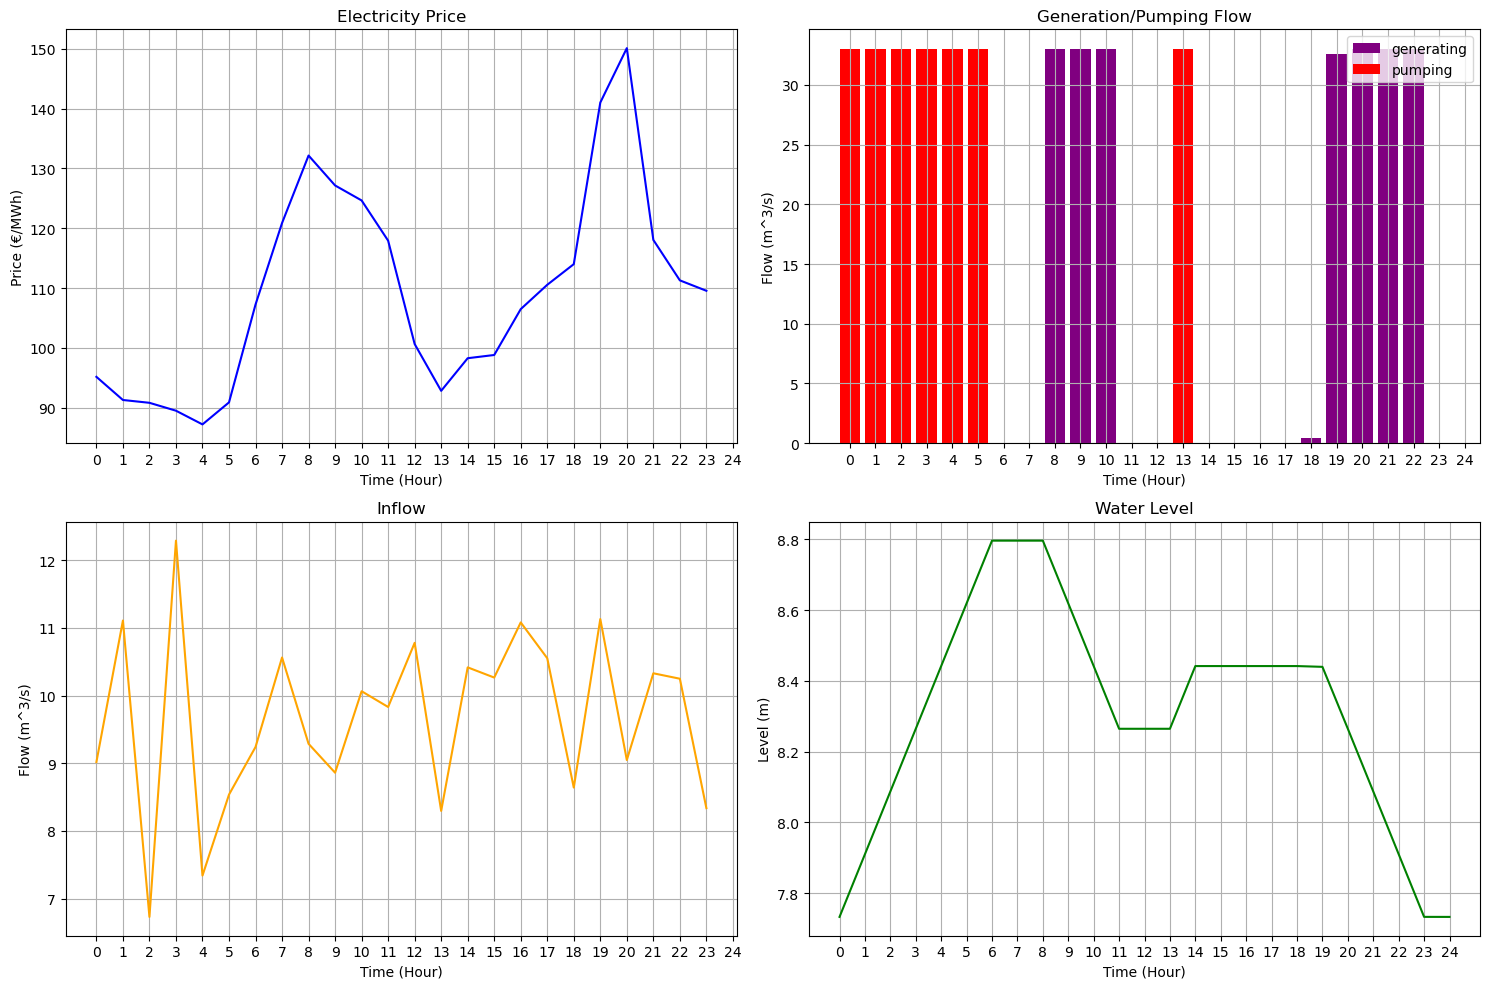

In [673]:
#Usage:
if __name__ == "__main__":    
    price = prices

    inflow = Inflow

    # Initial guess for flow rates (start with no flow)
    initial_flow_rates = np.zeros(time_steps)

    # Set up the constraints
    cons = constraints(initial_level)

    # Set the bounds for flow rates
    bounds = [(-max_flow_rate, max_flow_rate)] * time_steps

    # Solve the optimization problem
    result = minimize(objective_function, initial_flow_rates, args=(initial_level , price, inflow),
                        method='SLSQP', bounds=bounds, constraints=cons,
                        options={'disp': True, 'maxiter': 500})  # Increase maxiter
    # Print the results
    if result.success:
        print("Optimization successful!")
        optimal_flow_rates = result.x
        max_profit = -result.fun # Objective function returns negative of profit
        print(f"Maximum Profit: €{max_profit:,.2f}")

        # Calculate and print summary metrics
        energy_generated = 0
        energy_consumed = 0
        final_water_level = initial_level
        water_levels = [initial_level]  # Store water levels for plotting 
        for t in range(time_steps):
            flow_rate = optimal_flow_rates[t]
            head = max_head * (final_water_level / max_level)
            inflow_energy = inflow[t] * time_step_duration * head * efficiency_turbine * water_density * gravity #Wh
            if flow_rate > 0:
                power_out = efficiency_turbine * water_density * gravity * head * flow_rate #W
                power_out = min(power_out, max_power_turbine)
                energy_generated += power_out * time_step_duration #Wh
                final_water_level -= (flow_rate * time_step_duration) / reservoir_area
            elif flow_rate < 0:
                power_in = (water_density * gravity * head * abs(flow_rate)) * efficiency_pump #W
                energy_consumed += power_in * time_step_duration  #Wh
                final_water_level -= (flow_rate * time_step_duration) / reservoir_area
            water_levels.append(final_water_level)  # Store level at each time step

        print(f"Energy Generated from Inflow: {inflow_energy/1e9:,.2f} MWh")  # Convert Joules to kWh
        print(f"Total Energy Generated: {energy_generated / 1e9:,.2f} MWh")  # Convert Joules to kWh
        print(f"Total Energy Consumed: {energy_consumed / 1e9:,.2f} MWh")
        print(f"Final Water Level: {final_water_level:.2f} m")

  # --- Plotting ---
        time_hours = np.arange(0, time_steps + 1)  # For 25 points (0 to 24 inclusive)
        plt.figure(figsize=(15,10))  # Adjust figure size for a 2x2 grid

        # Plot 1: Electricity Price
        plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first subplot (top-left)
        plt.plot(time_hours[:-1], price, linestyle='-', color='b')
        plt.title('Electricity Price')
        plt.xlabel('Time (Hour)')
        plt.ylabel('Price (€/MWh)')
        plt.grid(True)
        plt.xticks(ticks=range(0, time_steps+1, days))

        # Plot 2: Optimized Generation
        plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second subplot (top-right)
        generation_flow_rates = np.where(optimal_flow_rates > 0, optimal_flow_rates, 0)
        plt.bar(time_hours[:-1], generation_flow_rates, color='purple', width=0.8, label ="generating")
        plt.bar(time_hours[:-1], pumping_flow_rates, color='red', width=0.8, label ="pumping")
        plt.title('Generation/Pumping Flow')
        plt.xlabel('Time (Hour)')
        plt.ylabel('Flow (m^3/s)')
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.xticks(ticks=range(0, time_steps+1, days))

        # Plot 3: Optimized Pumping
        plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third subplot (bottom-left)
        pumping_flow_rates = np.where(optimal_flow_rates < 0, -optimal_flow_rates, 0)  # Negate for positive values
        plt.plot(time_hours[:-1] ,inflow, linestyle='-', color = "orange")
        plt.title('Inflow')
        plt.xlabel('Time (Hour)')
        plt.ylabel('Flow (m^3/s)')
        plt.grid(True)
        plt.xticks(ticks=range(0, time_steps+1, days))

        # Plot 4: Water Level
        plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth subplot (bottom-right)
        plt.plot(time_hours, water_levels, linestyle='-', color='g')
        plt.title('Water Level')
        plt.xlabel('Time (Hour)')
        plt.ylabel('Level (m)')
        plt.grid(True)
        plt.xticks(ticks=range(0, time_steps+1, days))

        plt.tight_layout()
        plt.show()  # Display the plots
        
    else:
        print("Optimization failed.")
        print(result.message) # Print the error message